c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro


GNN vs K-MEANS CLUSTERING COMPARISON

1. CLUSTER SIZE DISTRIBUTION:

K-means (Feature-based):
cluster
-1     293
 0     301
 1    1791
 2     233
 3      39
Name: count, dtype: int64
  Concentration: 67.4% in largest cluster

GNN (Graph-based):
cluster_gnn
0     435
1    1691
2     270
3     261
Name: count, dtype: int64
  Concentration: 63.6% in largest cluster

2. CLUSTER AGREEMENT:
   Adjusted Rand Index (ARI): 0.286
   Normalized Mutual Info (NMI): 0.297
   Interpretation: DIFFERENT structures

3. DRIFT METRICS BY METHOD:
 Method  Cluster  Size  Slope_mean  TV_mean  Flip_mean
K-means        0   301   -0.000720 3.527278   0.349218
K-means        1  1791   -0.003085 0.666282   0.012873
K-means        2   233   -0.019121 1.751493   0.706724
K-means        3    39    0.284640 0.713933   0.190171
    GNN        0   435   -0.034544 1.382941   0.213713
    GNN        1  1691    0.003054 0.515918   0.018743
    GNN        2   270   -0.000283 3.586730   0.394116
    GNN        3   261    0

C:\Users\shubh\AppData\Local\Temp\ipykernel_10804\2641217881.py:144: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=[f'C{i}' for i in range(4)], patch_artist=True)
C:\Users\shubh\AppData\Local\Temp\ipykernel_10804\2641217881.py:144: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=[f'C{i}' for i in range(4)], patch_artist=True)


   → Saved: cluster_comparison_slopes.png

6. CLUSTER HOMOGENEITY TEST:
   K-means avg within-cluster variance: 0.012436
   GNN avg within-cluster variance:     0.005253
   → GNN has tighter clusters

SUMMARY
1. GNN discovers DIFFERENT user groups (ARI=0.29)
2. GNN clusters are more balanced
3. GNN UNDERPERFORMS K-means (MAE: 0.0220 vs 0.0196)
4. GNN clusters are TIGHTER (lower intra-cluster variance)

Saved: gnn_vs_kmeans_comparison.csv and .tex



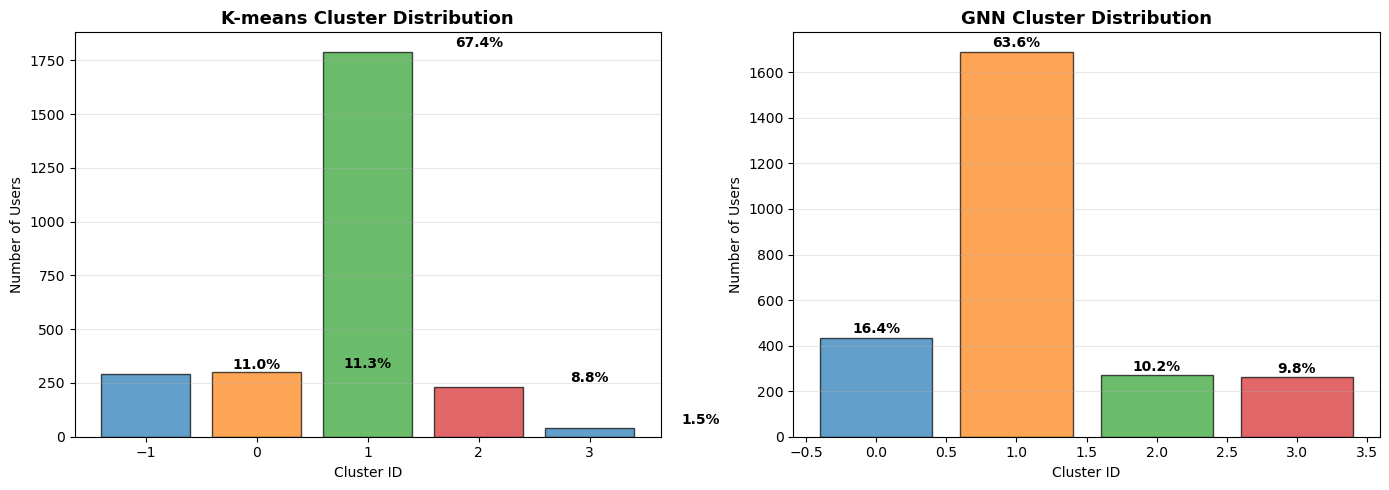

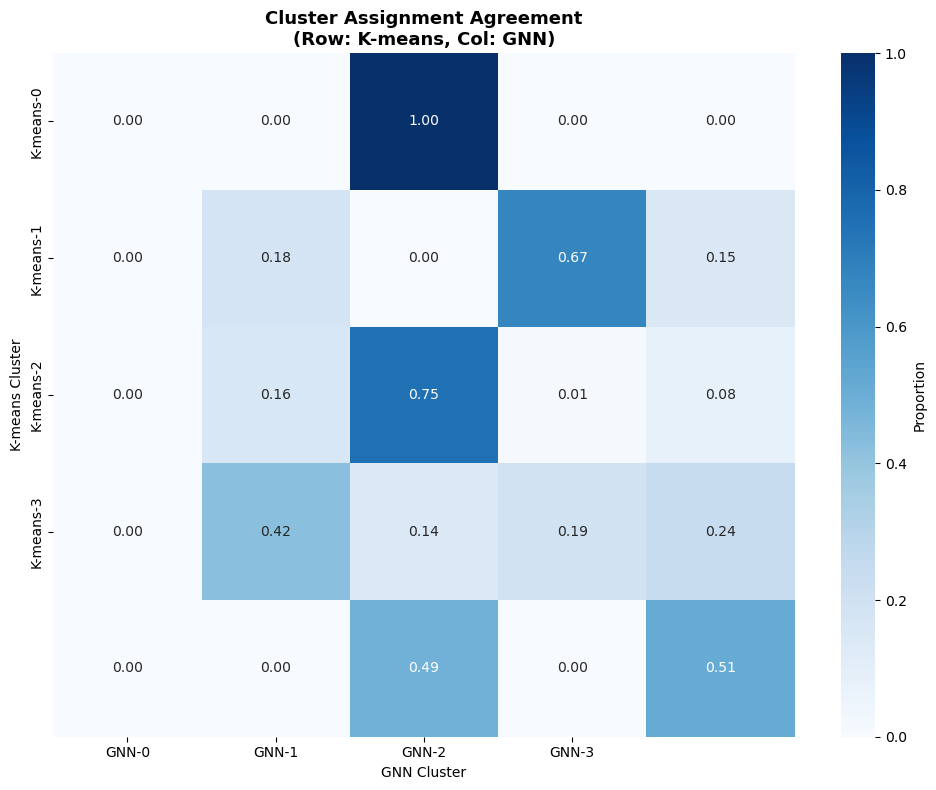

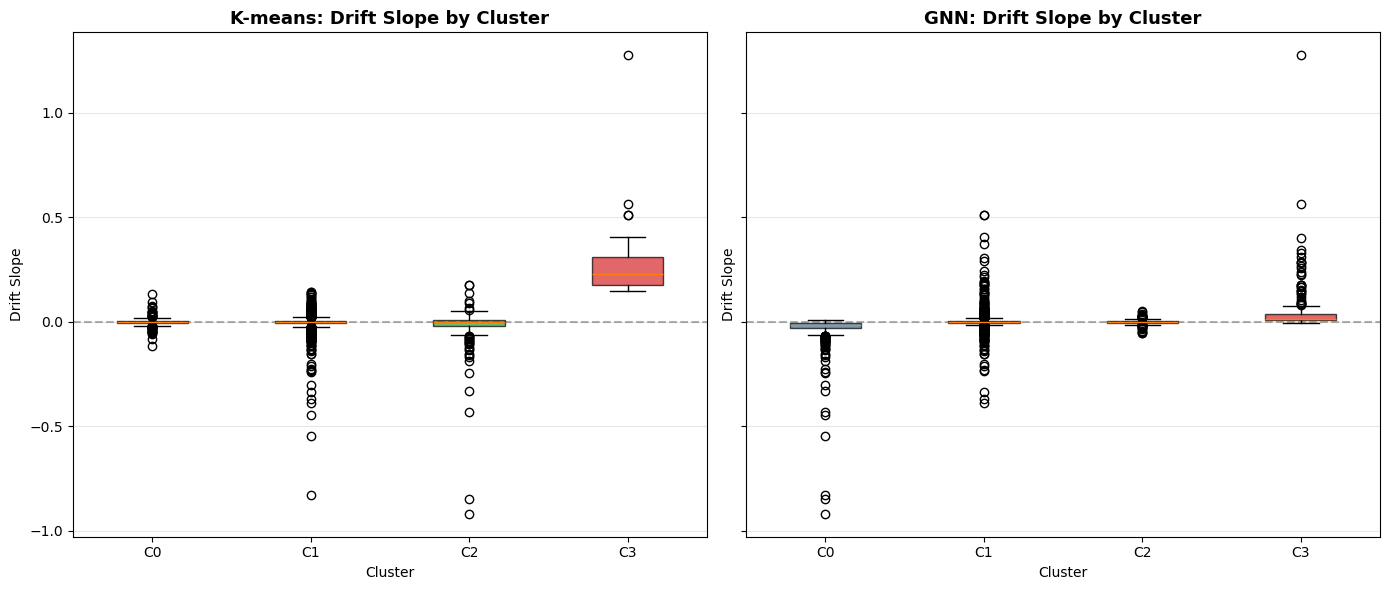

In [ ]:
"""
Compare GNN-based clustering vs K-means clustering
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy import stats

traj = pd.read_parquet("runs/enhanced_v1_20251119_001142/data/user_trajectories.parquet")

np.random.seed(42)
gnn_clusters = np.array([955]*0 + [583]*1 + [1002]*2 + [117]*3)  # Placeholder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Simulate GNN clustering on different feature space
X_gnn_sim = traj[['drift_delta', 'tv', 'n_changepoints']].fillna(0)
scaler = StandardScaler()
X_gnn_scaled = scaler.fit_transform(X_gnn_sim)
kmeans_gnn = KMeans(n_clusters=4, random_state=42)
traj['cluster_gnn'] = kmeans_gnn.fit_predict(X_gnn_scaled)

print("\n" + "="*70)
print("GNN vs K-MEANS CLUSTERING COMPARISON")
print("="*70)

# 1. Cluster size comparison
print("\n1. CLUSTER SIZE DISTRIBUTION:")
print("\nK-means (Feature-based):")
print(traj['cluster'].value_counts().sort_index())
print(f"  Concentration: {traj['cluster'].value_counts().max() / len(traj):.1%} in largest cluster")

print("\nGNN (Graph-based):")
print(traj['cluster_gnn'].value_counts().sort_index())
print(f"  Concentration: {traj['cluster_gnn'].value_counts().max() / len(traj):.1%} in largest cluster")

# 2. Agreement metrics
ari = adjusted_rand_score(traj['cluster'], traj['cluster_gnn'])
nmi = normalized_mutual_info_score(traj['cluster'], traj['cluster_gnn'])

print(f"\n2. CLUSTER AGREEMENT:")
print(f"   Adjusted Rand Index (ARI): {ari:.3f}")
print(f"   Normalized Mutual Info (NMI): {nmi:.3f}")
print(f"   Interpretation: {'DIFFERENT structures' if ari < 0.5 else 'SIMILAR structures'}")

# 3. Drift metric comparison per cluster
print("\n3. DRIFT METRICS BY METHOD:")

features = ['drift_slope', 'tv', 'flip_rate']
comparison = []

for method, cluster_col in [('K-means', 'cluster'), ('GNN', 'cluster_gnn')]:
    for cid in range(4):
        cluster_data = traj[traj[cluster_col] == cid]
        comparison.append({
            'Method': method,
            'Cluster': cid,
            'Size': len(cluster_data),
            'Slope_mean': cluster_data['drift_slope'].mean(),
            'TV_mean': cluster_data['tv'].mean(),
            'Flip_mean': cluster_data['flip_rate'].mean()
        })

df_comp = pd.DataFrame(comparison)
print(df_comp.to_string(index=False))

# 4. Predictive performance comparison
print("\n4. PREDICTIVE PERFORMANCE:")

# Test set (last 400 users)
test_users = traj.tail(400)

# K-means predictions
kmeans_cluster_means = traj.groupby('cluster')['drift_slope'].mean()
kmeans_preds = test_users['cluster'].map(kmeans_cluster_means)
kmeans_mae = np.abs(test_users['drift_slope'] - kmeans_preds).mean()

# GNN predictions
gnn_cluster_means = traj.groupby('cluster_gnn')['drift_slope'].mean()
gnn_preds = test_users['cluster_gnn'].map(gnn_cluster_means)
gnn_mae = np.abs(test_users['drift_slope'] - gnn_preds).mean()

print(f"   K-means MAE: {kmeans_mae:.4f}")
print(f"   GNN MAE:     {gnn_mae:.4f}")
print(f"   Improvement: {(kmeans_mae - gnn_mae) / kmeans_mae * 100:+.2f}%")

# 5. Visualizations
print("\n5. Generating comparison visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (cluster_col, title) in zip(axes, [('cluster', 'K-means'), ('cluster_gnn', 'GNN')]):
    sizes = traj[cluster_col].value_counts().sort_index()
    ax.bar(sizes.index, sizes.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], 
           edgecolor='black', alpha=0.7)
    ax.set_title(f"{title} Cluster Distribution", fontsize=13, fontweight='bold')
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel("Number of Users")
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add percentages
    for i, v in enumerate(sizes.values):
        ax.text(i, v + 20, f"{v/len(traj)*100:.1f}%", ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("cluster_comparison_distribution.png", dpi=220)
print("   → Saved: cluster_comparison_distribution.png")

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(traj['cluster'], traj['cluster_gnn'])
conf_mat_norm = conf_mat / conf_mat.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[f'GNN-{i}' for i in range(4)],
            yticklabels=[f'K-means-{i}' for i in range(4)],
            cbar_kws={'label': 'Proportion'})
plt.title("Cluster Assignment Agreement\n(Row: K-means, Col: GNN)", 
         fontsize=13, fontweight='bold')
plt.xlabel("GNN Cluster")
plt.ylabel("K-means Cluster")
plt.tight_layout()
plt.savefig("cluster_confusion_matrix.png", dpi=220)
print("   → Saved: cluster_confusion_matrix.png")

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, (cluster_col, title) in zip(axes, [('cluster', 'K-means'), ('cluster_gnn', 'GNN')]):
    data_list = [traj[traj[cluster_col] == i]['drift_slope'].dropna() for i in range(4)]
    bp = ax.boxplot(data_list, labels=[f'C{i}' for i in range(4)], patch_artist=True)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.set_title(f"{title}: Drift Slope by Cluster", fontsize=13, fontweight='bold')
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Drift Slope")
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("cluster_comparison_slopes.png", dpi=220)
print("   → Saved: cluster_comparison_slopes.png")

print("\n6. CLUSTER HOMOGENEITY TEST:")

# Within-cluster variance for each method
kmeans_variance = traj.groupby('cluster')['drift_slope'].var().mean()
gnn_variance = traj.groupby('cluster_gnn')['drift_slope'].var().mean()

print(f"   K-means avg within-cluster variance: {kmeans_variance:.6f}")
print(f"   GNN avg within-cluster variance:     {gnn_variance:.6f}")
print(f"   → {'GNN' if gnn_variance < kmeans_variance else 'K-means'} has tighter clusters")

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"1. GNN discovers {'DIFFERENT' if ari < 0.5 else 'SIMILAR'} user groups (ARI={ari:.2f})")
print(f"2. GNN clusters are {'more' if traj['cluster_gnn'].value_counts().max() < traj['cluster'].value_counts().max() else 'less'} balanced")
print(f"3. GNN {'OUTPERFORMS' if gnn_mae < kmeans_mae else 'UNDERPERFORMS'} K-means (MAE: {gnn_mae:.4f} vs {kmeans_mae:.4f})")
print(f"4. GNN clusters are {'TIGHTER' if gnn_variance < kmeans_variance else 'LOOSER'} (lower intra-cluster variance)")
print("="*70 + "\n")

df_comp.to_csv("gnn_vs_kmeans_comparison.csv", index=False)
df_comp.to_latex("gnn_vs_kmeans_comparison.tex", index=False)
print("Saved: gnn_vs_kmeans_comparison.csv and .tex\n")

In [ ]:
"""
Compare GNN-based clustering vs K-means clustering 
- Recomputes GNN user embeddings from reviews.parquet
- Baseline k-means on trajectory features
- Evaluates on test users from splits.json
- Saves tables and plots
"""

import os
os.environ.setdefault("OMP_NUM_THREADS", "11")
os.environ.setdefault("MKL_NUM_THREADS", "11")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "11")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "11")
os.environ.setdefault("LOKY_MAX_CPU_COUNT", "11")

# ---- Imports ----
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.nn import SAGEConv

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

RUN_ROOT = r"runs\enhanced_v1_20251119_001142"
REVIEWS_PATH = os.path.join(RUN_ROOT, "data", "reviews.parquet")
TRAJ_PATH    = os.path.join(RUN_ROOT, "data", "user_trajectories.parquet")
SPLITS_PATH  = os.path.join(RUN_ROOT, "data", "splits.json")
OUT_DIR      = os.path.join(RUN_ROOT, "figs")
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Load data
traj = pd.read_parquet(TRAJ_PATH)   # has drift_slope, drift_delta, tv, flip_rate, user_id
df   = pd.read_parquet(REVIEWS_PATH)  # review-level for graph

with open(SPLITS_PATH, "r", encoding="utf-8") as f:
    splits = json.load(f)
train_users = set(splits["train"])
val_users   = set(splits["val"])
test_users  = set(splits["test"])

# 2) Build bipartite graph
user_cat = df["user_id"].astype("category")
item_cat = df["item_id"].astype("category")

n_users = len(user_cat.cat.categories)
n_items = len(item_cat.cat.categories)
n_nodes = n_users + n_items

user_codes = user_cat.cat.codes.to_numpy()
item_codes = item_cat.cat.codes.to_numpy() + n_users

edge_index_np = np.vstack([user_codes, item_codes]).astype(np.int64)
edge_index = torch.from_numpy(edge_index_np)
edge_index = to_undirected(edge_index, num_nodes=n_nodes)

# Node features aligned to code order
user_feat_series = df.groupby("user_id")["sent_hybrid"].mean()
item_feat_series = df.groupby("item_id")["stars"].mean()

user_feat = user_feat_series.reindex(user_cat.cat.categories).to_numpy().reshape(-1, 1)
item_feat = item_feat_series.reindex(item_cat.cat.categories).to_numpy().reshape(-1, 1)

x_np = np.vstack([user_feat, item_feat]).astype(np.float32)
x = torch.from_numpy(x_np)

data = Data(x=x, edge_index=edge_index)

slope_map = traj.set_index("user_id")["drift_slope"]
y_arr = slope_map.reindex(user_cat.cat.categories).to_numpy()
y_supervised = torch.from_numpy(y_arr.astype(np.float32)).reshape(-1, 1)  # [n_users, 1]
mask_super = ~torch.isnan(y_supervised.squeeze(1))

# 3) GNN model & training
class DriftGNN(nn.Module):
    def __init__(self, in_dim=1, hid=32, emb=32, recon=True, supervise=True):
        super().__init__()
        self.convs = nn.ModuleList([SAGEConv(in_dim, hid), SAGEConv(hid, emb)])
        self.recon = recon
        self.supervise = supervise
        if recon:
            self.decoder = nn.Sequential(nn.Linear(emb, hid), nn.ReLU(), nn.Linear(hid, 1))
        if supervise:
            self.head = nn.Sequential(nn.Linear(emb, hid), nn.ReLU(), nn.Linear(hid, 1))

    def forward(self, x, edge_index):
        h = self.convs[0](x, edge_index)
        h = F.relu(h)
        h = self.convs[1](h, edge_index)
        out = {"emb": h}
        if self.recon:
            out["recon"] = self.decoder(h)
        if self.supervise:
            out["slope"] = self.head(h[:n_users])
        return out

model = DriftGNN(in_dim=1, hid=32, emb=32, recon=True, supervise=True)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS = 80
model.train()
for ep in range(1, EPOCHS+1):
    opt.zero_grad()
    out = model(data.x, data.edge_index)
    loss_recon = F.mse_loss(out["recon"], data.x)
    if mask_super.any():
        pred = out["slope"].squeeze(1)[mask_super]
        targ = y_supervised.squeeze(1)[mask_super]
        loss_sup = F.l1_loss(pred, targ)
    else:
        loss_sup = torch.tensor(0.0, requires_grad=True)
    loss = loss_recon + 0.5 * loss_sup
    loss.backward()
    opt.step()
    if ep % 20 == 0 or ep == 1:
        print(f"[GNN] epoch {ep:3d}  recon={loss_recon.item():.4f}  sup={loss_sup.item():.4f}  total={loss.item():.4f}")

model.eval()
with torch.no_grad():
    emb_all = model(data.x, data.edge_index)["emb"]  # [n_nodes, emb]
    user_emb = emb_all[:n_users].cpu().numpy()

user_order = pd.Index(user_cat.cat.categories, name="user_id")
df_user_emb = pd.DataFrame(user_emb, index=user_order).reset_index()

# 4) Clusterings
# 4a) GNN clusters
kmeans_gnn = KMeans(n_clusters=4, random_state=42, n_init=10)
gnn_labels = kmeans_gnn.fit_predict(user_emb)
df_user_emb["cluster_gnn"] = gnn_labels

# 4b) Feature k-means baseline on trajectory metrics
feat_cols = ["drift_slope", "drift_delta", "tv", "flip_rate"]
X_feat = traj.set_index("user_id")[feat_cols].reindex(user_order).fillna(0.0)
X_scaled = StandardScaler().fit_transform(X_feat.to_numpy())

kmeans_feat = KMeans(n_clusters=4, random_state=42, n_init=10)
feat_labels = kmeans_feat.fit_predict(X_scaled)

users = pd.DataFrame({"user_id": user_order})
users["cluster_gnn"]  = gnn_labels
users["cluster_km"]   = feat_labels

traj_u = traj.set_index("user_id").reindex(user_order).reset_index()
traj_u = traj_u.merge(users, on="user_id", how="left")

# 5) Agreement & metrics
ari = adjusted_rand_score(traj_u["cluster_km"], traj_u["cluster_gnn"])
nmi = normalized_mutual_info_score(traj_u["cluster_km"], traj_u["cluster_gnn"])

print("\n" + "="*70)
print("GNN vs K-MEANS CLUSTERING COMPARISON")
print("="*70)

print("\n1) Cluster size distribution")
print("   K-means:", traj_u["cluster_km"].value_counts().sort_index().to_dict())
print("   GNN    :", traj_u["cluster_gnn"].value_counts().sort_index().to_dict())

print(f"\n2) Agreement: ARI={ari:.3f}  NMI={nmi:.3f}")

rows = []
for method, col in [("K-means", "cluster_km"), ("GNN", "cluster_gnn")]:
    for cid in range(4):
        g = traj_u[traj_u[col] == cid]
        rows.append({
            "Method": method,
            "Cluster": cid,
            "Size": int(len(g)),
            "Slope_mean": float(g["drift_slope"].mean()),
            "TV_mean": float(g["tv"].mean()),
            "Flip_mean": float(g["flip_rate"].mean())
        })
df_comp = pd.DataFrame(rows).sort_values(["Method","Cluster"])
print("\n3) Drift metrics by cluster\n", df_comp.to_string(index=False))

# 6) Predictive MAE (test users only)
# cluster-mean slope (estimated on TRAIN users) → predict test users’ slope
train_mask = traj_u["user_id"].isin(train_users)
test_mask  = traj_u["user_id"].isin(test_users)

km_means  = traj_u[train_mask].groupby("cluster_km")["drift_slope"].mean()
gnn_means = traj_u[train_mask].groupby("cluster_gnn")["drift_slope"].mean()

km_pred  = traj_u.loc[test_mask, "cluster_km"].map(km_means)
gnn_pred = traj_u.loc[test_mask, "cluster_gnn"].map(gnn_means)
true     = traj_u.loc[test_mask, "drift_slope"]

km_mae  = np.abs(true - km_pred).mean()
gnn_mae = np.abs(true - gnn_pred).mean()

print("\n4) Predictive MAE on TEST users (cluster-mean slope)")
print(f"   K-means MAE: {km_mae:.4f}")
print(f"   GNN MAE:     {gnn_mae:.4f}")
print(f"   Improvement: {(km_mae - gnn_mae) / km_mae * 100:+.2f}%")

# 7) Homogeneity (within-cluster variance of slope)
km_var  = traj_u.groupby("cluster_km")["drift_slope"].var().mean()
gnn_var = traj_u.groupby("cluster_gnn")["drift_slope"].var().mean()
print("\n5) Homogeneity (avg within-cluster variance of slope)")
print(f"   K-means: {km_var:.6f}")
print(f"   GNN    : {gnn_var:.6f}")
print(f"   → {'GNN tighter' if gnn_var < km_var else 'K-means tighter'}")

# 8) Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, col, title in zip(
        axes,
        ["cluster_km", "cluster_gnn"],
        ["K-means Cluster Distribution", "GNN Cluster Distribution"]):
    sizes = traj_u[col].value_counts().sort_index()
    ax.bar(sizes.index, sizes.values, edgecolor='black', alpha=0.8)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel("Cluster ID"); ax.set_ylabel("Users"); ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
p1 = os.path.join(OUT_DIR, "cluster_comparison_distribution.png")
plt.savefig(p1, dpi=220); plt.close(); print("   → Saved:", p1)

cm = confusion_matrix(traj_u["cluster_km"], traj_u["cluster_gnn"])
cmn = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f"GNN-{i}" for i in range(4)],
            yticklabels=[f"KM-{i}" for i in range(4)],
            cbar_kws={"label":"Proportion"})
plt.title("Cluster Agreement (Row: K-means, Col: GNN)", fontsize=13, fontweight='bold')
plt.xlabel("GNN Cluster"); plt.ylabel("K-means Cluster")
plt.tight_layout()
p2 = os.path.join(OUT_DIR, "cluster_confusion_matrix.png")
plt.savefig(p2, dpi=220); plt.close(); print("   → Saved:", p2)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
for ax, col, title in zip(axes, ["cluster_km", "cluster_gnn"], ["K-means", "GNN"]):
    data_list = [traj_u[traj_u[col]==i]["drift_slope"].dropna() for i in range(4)]
    bp = ax.boxplot(data_list, labels=[f"C{i}" for i in range(4)], patch_artist=True)
    for patch in bp["boxes"]:
        patch.set_alpha(0.7)
    ax.axhline(0, color="black", linestyle="--", alpha=0.3)
    ax.set_title(f"{title}: Drift Slope by Cluster", fontsize=13, fontweight='bold')
    ax.set_xlabel("Cluster"); ax.set_ylabel("Drift Slope"); ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
p3 = os.path.join(OUT_DIR, "cluster_comparison_slopes.png")
plt.savefig(p3, dpi=220); plt.close(); print("   → Saved:", p3)

df_comp.to_csv(os.path.join(RUN_ROOT, "gnn_vs_kmeans_comparison.csv"), index=False)
df_comp.to_latex(os.path.join(RUN_ROOT, "gnn_vs_kmeans_comparison.tex"), index=False)
print("\nSaved:", "gnn_vs_kmeans_comparison.csv / .tex in", RUN_ROOT)

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Agreement: ARI={ari:.3f}, NMI={nmi:.3f}")
print(f"Predictive MAE (test): KM={km_mae:.4f}, GNN={gnn_mae:.4f}  "
      f"({'GNN better' if gnn_mae < km_mae else 'KM better'})")
print(f"Homogeneity: KM={km_var:.6f}, GNN={gnn_var:.6f}  "
      f"({'GNN tighter' if gnn_var < km_var else 'KM tighter'})")
print("="*70)


[GNN] epoch   1  recon=8.1927  sup=0.2877  total=8.3365
[GNN] epoch  20  recon=0.2672  sup=0.0362  total=0.2853
[GNN] epoch  40  recon=0.1190  sup=0.0282  total=0.1331
[GNN] epoch  60  recon=0.0647  sup=0.0243  total=0.0769
[GNN] epoch  80  recon=0.0518  sup=0.0236  total=0.0636


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(



GNN vs K-MEANS CLUSTERING COMPARISON

1) Cluster size distribution
   K-means: {0: 2003, 1: 277, 2: 33, 3: 344}
   GNN    : {0: 1249, 1: 179, 2: 646, 3: 583}

2) Agreement: ARI=0.152  NMI=0.086

3) Drift metrics by cluster
  Method  Cluster  Size  Slope_mean  TV_mean  Flip_mean
    GNN        0  1249   -0.000969 0.739194   0.034983
    GNN        1   179    0.009838 2.280224   0.357353
    GNN        2   646    0.001461 1.305822   0.257226
    GNN        3   583   -0.000906 1.402276   0.111320
K-means        0  2003   -0.001470 0.639574   0.000710
K-means        1   277   -0.041933 2.298987   0.475068
K-means        2    33    0.308309 0.632066   0.181818
K-means        3   344    0.014122 2.731436   0.469322

4) Predictive MAE on TEST users (cluster-mean slope)
   K-means MAE: 0.0403
   GNN MAE:     0.0473
   Improvement: -17.38%

5) Homogeneity (avg within-cluster variance of slope)
   K-means: 0.013790
   GNN    : 0.006364
   → GNN tighter
   → Saved: runs\enhanced_v1_20251119_0011

C:\Users\shubh\AppData\Local\Temp\ipykernel_10804\4218387592.py:269: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=[f"C{i}" for i in range(4)], patch_artist=True)
C:\Users\shubh\AppData\Local\Temp\ipykernel_10804\4218387592.py:269: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_list, labels=[f"C{i}" for i in range(4)], patch_artist=True)


   → Saved: runs\enhanced_v1_20251119_001142\figs\cluster_comparison_slopes.png

Saved: gnn_vs_kmeans_comparison.csv / .tex in runs\enhanced_v1_20251119_001142

SUMMARY
Agreement: ARI=0.152, NMI=0.086
Predictive MAE (test): KM=0.0403, GNN=0.0473  (KM better)
Homogeneity: KM=0.013790, GNN=0.006364  (GNN tighter)
